In [38]:
import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import jax.random as jr
import matplotlib.pyplot as plt

In [109]:
import jax
import jax.numpy as jnp
import equinox as eqx
import jax.random as jr

class Generator(eqx.Module):
    downsample_layers_01: list
    downsample_layers_02: list

    def __init__(self, latent_size, key: jr.PRNGKey):
        keys = jr.split(key, 10)
        self.downsample_layers_01 = [
            eqx.nn.Linear(in_features=latent_size, out_features=7*7*256, key=keys[0]),
            eqx.nn.BatchNorm(input_size=7*7*256, axis_name=("batch",)),
            jax.nn.leaky_relu,
        ]

        self.downsample_layers_02 = [
            eqx.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=128, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=64, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[1]),
          
            
            # Adicione mais camadas conforme necessário
        ]

    def __call__(self, x, state):
        for layer in self.downsample_layers_01:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            else:
                x = layer(x)
            print(x.shape)
            
            
        x = jnp.reshape(x, (256, 7, 7))
        print(x.shape)

        for layer in self.downsample_layers_02:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            else:
                x = layer(x)
            
            print(x.shape)

        
        return x, state

[[ 1.3969241   0.25045034 -2.1396856  ...  0.3145455  -1.4147886
  -0.9089208 ]
 [-0.7179685  -0.55156016  0.5488421  ...  1.0389216   0.6316356
   1.2083954 ]
 [ 0.1089396   0.41924244  0.61395687 ... -0.25856677  2.026924
  -0.840388  ]
 ...
 [-1.7753865   0.47193787 -1.0666512  ... -0.05554172  1.7904825
  -0.38509572]
 [ 1.1479     -0.8108315  -0.14811768 ...  0.29534367  0.20607775
  -0.40122998]
 [-0.8252757   0.60466516  2.5560381  ...  0.07566901  1.3775586
   0.7038264 ]]
(100, 100)
(12544,)
(12544,)
(12544,)
(256, 7, 7)
(128, 7, 7)
(128, 7, 7)
(128, 7, 7)
(64, 14, 14)
(64, 14, 14)
(64, 14, 14)
(1, 28, 28)
[[[[-0.07859795  0.1295204  -0.18964335 ...  0.18645859 -0.15645547
    -0.09712529]
   [-0.02747948 -0.29628736  0.04462486 ... -0.08713172  0.0568141
     0.01094011]
   [-0.06864631 -0.02243936 -0.46335402 ...  0.13310924 -0.33774254
     0.15776825]
   ...
   [-0.06418999 -0.0822463   0.00988162 ... -0.06248939  0.06117838
     0.01295455]
   [-0.13859662 -0.06436513 -0.

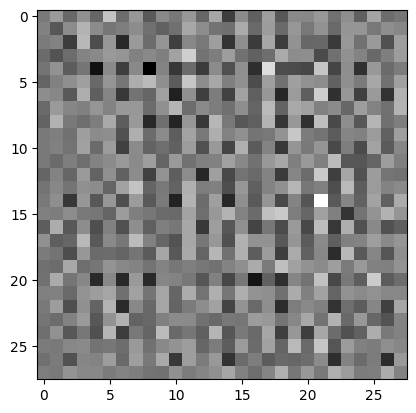

In [110]:
key = jr.PRNGKey(0)
latent_size = 100


generator = Generator(latent_size, key=key)
generator_state = eqx.nn.State(generator)


test_tensor = jr.normal(key, (100, latent_size))
print(test_tensor)
print(test_tensor.shape)

output, generator_state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, generator_state)

print(output)

images = output
print(images.min())
print(images.max())
images = (images - images.min()) / (images.max() - images.min())
plt.imshow(images[0, 0], cmap='gray')
plt.show()

